<a href="https://colab.research.google.com/github/ciepielajan/Multi-Class-Classification-NLP/blob/main/Detecting_intentions_MLP-clean-lemma-stop_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Pobranie danych

In [1]:
# https://drive.google.com/file/d/1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq/view?usp=sharing
!gdown --id "1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq"

Downloading...
From: https://drive.google.com/uc?id=1fI6EXyD9TMTC1jzdu206ljXOGNjdHprq
To: /content/user_intent.zip
100% 271k/271k [00:00<00:00, 39.4MB/s]


In [2]:
!unzip "user_intent.zip"

Archive:  user_intent.zip
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    
  inflating: validation.csv          


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime

data_set_train = pd.read_csv("train.csv")
data_set_valid = pd.read_csv("validation.csv")

print(data_set_train.shape)
print(data_set_valid.shape)

print(data_set_train.columns)
print(data_set_valid.columns)

(13784, 2)
(700, 2)
Index(['text', 'label'], dtype='object')
Index(['text', 'label'], dtype='object')


#### Podstawowy process text

In [4]:
import re
def process_text(sentence):
    sentence = re.sub('[A-Za-z0-9]+@[a-zA-z].[a-zA-Z]+', '', sentence)  # maile
    sentence = re.sub('(http[s]*:[/][/])[a-zA-Z0-9]+', '', sentence)  # linki
    sentence = re.sub(r"<[^>]+>", " ", sentence) # remove html tag
    sentence = re.sub(r"[^a-zA-Z\s]", "", sentence)  # remove punctuations and numbers   
    sentence = re.sub(r"\b[A-Za-z]{1}\b", "", sentence)  # remove single characters

    sentence = re.sub("^\s+|\s+$", "", sentence, flags=re.UNICODE) # Remove spaces both in the BEGINNING and in the END of a string:
    sentence = " ".join(re.split("\s+", sentence, flags=re.UNICODE))  # Remove ONLY DUPLICATE spaces:
    sentence = sentence.lower()
    
    return sentence

In [5]:
data_set_train["clean_text"] = data_set_train["text"].apply(lambda x: process_text(x))

#### `SpaCy` `Lemmatyzacja` i usunięcie `stop_words`

In [6]:
import spacy
# pobranie angielskich STOP WORDS (słów nie mających znaczenia)
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)
print(stopwords)

# załadowanie angielskiego CORE 
nlp = spacy.load('en_core_web_sm')

['also', 'much', 'fifty', 'us', '’d', 'off', 'when', 'none', 'over', 'anywhere', 'more', 'have', 'her', 'bottom', 'cannot', 'this', 'whoever', 'has', 'without', 'otherwise', 'your', 'elsewhere', 'serious', 'she', 'herself', 'thru', 'through', 'be', 'whence', 'hence', 'yourselves', 'hereby', 'almost', 'others', 'seem', 'done', 'go', 'forty', 'hereafter', 'below', 'give', 'into', 'from', 'everywhere', 'own', 'a', 'where', 'toward', 'unless', 'such', 'back', 'name', 'alone', 'using', 'twelve', 'before', 'quite', 'the', 'which', 'whom', 'well', 'amount', 'else', 'himself', 'about', 'thereupon', 'get', 'whereafter', 'nobody', 'being', 'whole', '‘ll', 'onto', 'however', 'two', '’m', 'if', 'too', 'neither', 'never', 'now', 'had', 'among', 'nowhere', 'afterwards', 'could', 'for', 'as', '’ve', 'what', 'though', 'yourself', 'often', 'everyone', 'keep', 'must', "'d", 'then', 'part', 'even', 'above', 'you', '’s', 'that', 'become', "'ve", 'down', 'former', 'thence', 'perhaps', 'am', 'after', 'made'

In [7]:
spacy.__version__

'2.2.4'

In [8]:
%%time
data_set_train["tokens_lemma_without_stop"] = data_set_train["clean_text"].apply(lambda x: " ".join([str(i.lemma_ ) for i in nlp(x) if i.lemma_  != "-PRON-" and i.lemma_ not in stopwords ]))

CPU times: user 2min 46s, sys: 172 ms, total: 2min 46s
Wall time: 2min 47s


In [9]:
data_set_train.sample(5)

,text,label,clean_text,tokens_lemma_without_stop
9462,Include Badmeaningood Volume4 in jaime's Anima...,AddToPlaylist,include badmeaningood volume in jaimes animal ...,include badmeaningood volume jaime animal stor...
6497,The Songs to Sing in the Car playlist needs k ...,AddToPlaylist,the songs to sing in the car playlist needs ye...,song sing car playlist need yesudas discography
8925,I'd like a table for 3 at a brasserie in Hillv...,BookRestaurant,id like table for at brasserie in hillview ne ...,like table brasserie hillview ne mineiro
11692,Can you make reservations for 1 person in IL,BookRestaurant,can you make reservations for person in il,reservation person il
5244,Fine movie times for Loews Cineplex Entertainm...,SearchScreeningEvent,fine movie times for loews cineplex entertainment,fine movie time loews cineplex entertainment


In [10]:
id_intention = 6
print("Surowy tekst")
print(data_set_train["text"].iloc[id_intention])
print("Po oczyszczeniu")
print(data_set_train["clean_text"].iloc[id_intention])
print("Po lematyzacji i usunięciu stop words")
print(data_set_train["tokens_lemma_without_stop"].iloc[id_intention])

Surowy tekst
Book a table for 10 people at a restaurant which offers internet.
Po oczyszczeniu
book table for people at restaurant which offers internet
Po lematyzacji i usunięciu stop words
book table people restaurant offer internet


#### `LabelEncoder` oraz `to_categorical`

In [11]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical 


labelencoder = LabelEncoder()
data_set_train["labelencoder"] = labelencoder.fit_transform(data_set_train["label"])

dummy_y = to_categorical(data_set_train["labelencoder"], dtype ="float32")

data_set_train[["clean_text","label","labelencoder"]].head(5)

,clean_text,label,labelencoder
0,find cinema nearest for films,SearchScreeningEvent,6
1,give the current series two stars,RateBook,4
2,find the good girl at movie house,SearchScreeningEvent,6
3,please make reservations for three at kosher t...,BookRestaurant,1
4,what is the forecast for here one second from now,GetWeather,2


In [12]:
dummy_y.shape

(13784, 7)

In [13]:
id_intention = 6
print("Sprawdzenie poprawności LabelEncoder i to_categorical \n")
print("Label - ", data_set_train["label"].iloc[id_intention])
print("LabelEncoder - ", data_set_train["labelencoder"].iloc[id_intention])
print()
print("to_categorical - ", dummy_y[id_intention])
print()
print("return to LabelEncoder - ",np.argmax(dummy_y[id_intention], axis=-1))
print("return to Label - ",labelencoder.inverse_transform([np.argmax(dummy_y[id_intention], axis=-1)]))

Sprawdzenie poprawności LabelEncoder i to_categorical 

Label -  BookRestaurant
LabelEncoder -  1

to_categorical -  [0. 1. 0. 0. 0. 0. 0.]

return to LabelEncoder -  1
return to Label -  ['BookRestaurant']


#### Zdefiniowanie X i y

In [14]:
X = data_set_train["tokens_lemma_without_stop"]
y = dummy_y

In [15]:
X.shape, y.shape

((13784,), (13784, 7))

#### Podział zbioru 

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11027,), (2757,), (11027, 7), (2757, 7))

#### `Tokenizer` i `pad_sequences`

In [18]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [19]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 7
vocab_size = len(tokenizer.word_index) + 1

X_train = pad_sequences(X_train, padding="post", truncating="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", truncating="post", maxlen=maxlen)

In [20]:
from keras.models import Sequential
from keras.layers import Flatten, SimpleRNN, Dense
from keras.layers.embeddings import Embedding
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))  
model.add(Flatten())
model.add(Dense(7, activation="softmax")) # sigmoid / softmax
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            894300    
_________________________________________________________________
flatten (Flatten)            (None, 700)               0         
_________________________________________________________________
dense (Dense)                (None, 7)                 4907      
Total params: 899,207
Trainable params: 899,207
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=5,
                          verbose=1)

history = model.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_split=0.2, 
                    callbacks = [EarlyStop] )
scores = model.evaluate(X_test, y_test)
print(f"Accuracy {scores[1] * 100}")

Epoch 1/20
138/138 [==============================] - 2s 11ms/step - loss: 1.6639 - accuracy: 0.5910 - val_loss: 0.5472 - val_accuracy: 0.9207
Epoch 2/20
138/138 [==============================] - 1s 7ms/step - loss: 0.3851 - accuracy: 0.9455 - val_loss: 0.2234 - val_accuracy: 0.9492
Epoch 3/20
138/138 [==============================] - 1s 7ms/step - loss: 0.1439 - accuracy: 0.9748 - val_loss: 0.1590 - val_accuracy: 0.9578
Epoch 4/20
138/138 [==============================] - 1s 7ms/step - loss: 0.0856 - accuracy: 0.9834 - val_loss: 0.1343 - val_accuracy: 0.9624
Epoch 5/20
138/138 [==============================] - 1s 7ms/step - loss: 0.0619 - accuracy: 0.9867 - val_loss: 0.1238 - val_accuracy: 0.9615
Epoch 6/20
138/138 [==============================] - 1s 7ms/step - loss: 0.0436 - accuracy: 0.9912 - val_loss: 0.1173 - val_accuracy: 0.9642
Epoch 7/20
138/138 [==============================] - 1s 7ms/step - loss: 0.0355 - accuracy: 0.9920 - val_loss: 0.1129 - val_accuracy: 0.9642
Epoch

In [23]:
print(f"Accuracy {scores[1] * 100}")

Accuracy 96.77185416221619


#### Predykcja na zbiorze validacyjnym

In [24]:
# oczysczenie danych
data_set_valid["clean_text"] = data_set_valid["text"].apply(lambda x: process_text(x))
data_set_valid["tokens_lemma_without_stop"] = data_set_valid["clean_text"].apply(lambda x: " ".join([str(i.lemma_ ) for i in nlp(x) if i.lemma_  != "-PRON-" and i.lemma_ not in stopwords ]))

# labelencoder 
data_set_valid["labelencoder"] = labelencoder.fit_transform(data_set_valid["label"])

# tokenizacja weg przetrenowanego już tokenizera
X_validate = tokenizer.texts_to_sequences(data_set_valid["clean_text"])

# pad sequel
X_validate = pad_sequences(X_validate, padding="post", truncating="post", maxlen=maxlen)
X_validate

array([[ 337,   31,    0, ...,    0,    0,    0],
       [ 152,  210,    1, ...,  300,    0,    0],
       [ 183,   16,   56, ...,  849,    0,    0],
       ...,
       [  43,    0,    0, ...,    0,    0,    0],
       [   8,   16, 2406, ...,    0,    0,    0],
       [  23,   19,   93, ..., 1458,    0,    0]], dtype=int32)

In [25]:
dummy_y_valid = data_set_valid["labelencoder"].values
dummy_y_valid[:5]

array([6, 3, 2, 0, 6])

In [26]:
# Sprawdzenie rozmiaru zbiorów validacyjnego
X_validate.shape, dummy_y_valid.shape

((700, 7), (700,))

In [27]:
predicted_lstm_val = np.argmax(model.predict(X_validate), axis=-1)
predicted_lstm_val[:5]

array([6, 3, 2, 0, 6])

#### Rozkodowanie przewidzianych i prawidłowych etykiet

In [28]:
y_pred = labelencoder.inverse_transform(predicted_lstm_val)
y_pred = pd.Series(y_pred)
y_pred.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

In [29]:
y_val = labelencoder.inverse_transform(dummy_y_valid)
y_val = pd.Series(y_val)
y_val.head()

0    SearchScreeningEvent
1               PlayMusic
2              GetWeather
3           AddToPlaylist
4    SearchScreeningEvent
dtype: object

#### `Confusion matrix`

In [30]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

Accuracy: 0.94
F1_score: 0.94
                      precision    recall  f1-score   support

       AddToPlaylist       0.99      1.00      1.00       100
      BookRestaurant       0.99      0.97      0.98       100
          GetWeather       0.96      0.99      0.98       100
           PlayMusic       1.00      0.93      0.96       100
            RateBook       0.97      0.87      0.92       100
  SearchCreativeWork       0.78      0.97      0.87       100
SearchScreeningEvent       0.92      0.84      0.88       100

            accuracy                           0.94       700
           macro avg       0.94      0.94      0.94       700
        weighted avg       0.94      0.94      0.94       700



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

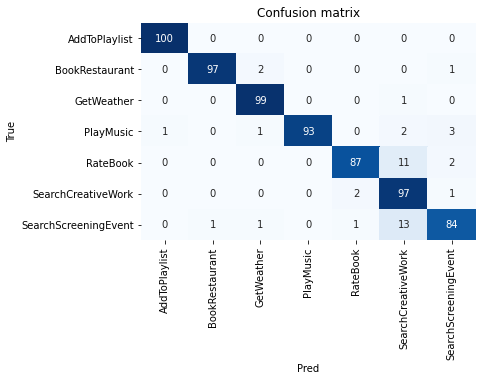

In [31]:
classes = np.unique(y_val)

print('Accuracy:', round(accuracy_score(y_val, y_pred),2))
print('F1_score:', round(f1_score(y_val, y_pred, average='weighted'),2))

print(classification_report(y_val, y_pred))
# Plot confusion matrix
cm = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xlabel='Pred', ylabel='True', xticklabels=classes, yticklabels=classes, title='Confusion matrix')
plt.yticks(rotation=0)
plt.xticks(rotation=90)

#### Zapoznanie się z błędnymi predykcjami 

In [32]:
indexes = []
for i, phrase in enumerate(y_pred):
  if phrase == 'SearchCreativeWork':
    if y_val[i] == 'SearchScreeningEvent':
      indexes.append(i)
print(indexes)

[6, 125, 145, 346, 381, 402, 519, 557, 568, 590, 615, 648, 689]


In [33]:
for i in indexes:
  print(f"----------------------------\nTekst komendy:\n{data_set_valid['text'][i]}")
  print(f"Oczyszczona komenda:\n{data_set_valid['tokens_lemma_without_stop'][i]}")
  print(f'True category: {y_val[i]}')
  print(f'Predicted category: {y_pred[i]}')
  print("\n")

----------------------------
Tekst komendy:
I want to see While the Sun Shines at the closest movie house.
Oczyszczona komenda:
want sun shine close movie house
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
what are the times for The Gingerbread Man
Oczyszczona komenda:
time gingerbread man
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Medal for the General
Oczyszczona komenda:
want medal general
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
I want to see Those Kids from Town, when will it be showing?
Oczyszczona komenda:
want kid town
True category: SearchScreeningEvent
Predicted category: SearchCreativeWork


----------------------------
Tekst komendy:
Show me the movies at Harkins Theatres.
Oczyszczona komenda:
movie harkin theatre
True category: S


#### Wnioski: 
> stop_words  usuneło słowa tj `show`, `see` które powtarzają się w kilku błędnie przewidzianych predykcjach. Aby przewidzieć intencje czasowniki są istotne i nie mogą zostać usunięte. 



In [69]:
doc = nlp("show see")
print(doc)

[ i for i in doc if i.text in stopwords]

show see


[show, see]

In [72]:
print(stopwords)

['also', 'much', 'fifty', 'us', '’d', 'off', 'when', 'none', 'over', 'anywhere', 'more', 'have', 'her', 'bottom', 'cannot', 'this', 'whoever', 'has', 'without', 'otherwise', 'your', 'elsewhere', 'serious', 'she', 'herself', 'thru', 'through', 'be', 'whence', 'hence', 'yourselves', 'hereby', 'almost', 'others', 'seem', 'done', 'go', 'forty', 'hereafter', 'below', 'give', 'into', 'from', 'everywhere', 'own', 'a', 'where', 'toward', 'unless', 'such', 'back', 'name', 'alone', 'using', 'twelve', 'before', 'quite', 'the', 'which', 'whom', 'well', 'amount', 'else', 'himself', 'about', 'thereupon', 'get', 'whereafter', 'nobody', 'being', 'whole', '‘ll', 'onto', 'however', 'two', '’m', 'if', 'too', 'neither', 'never', 'now', 'had', 'among', 'nowhere', 'afterwards', 'could', 'for', 'as', '’ve', 'what', 'though', 'yourself', 'often', 'everyone', 'keep', 'must', "'d", 'then', 'part', 'even', 'above', 'you', '’s', 'that', 'become', "'ve", 'down', 'former', 'thence', 'perhaps', 'am', 'after', 'made'

In [76]:
# sprawdzmy ile innych czasowników znajduje się w liście stopwords

doc = nlp(" ".join(stopwords))
VERB_list_stopwords = []
for token in doc:
  if token.pos_ == "VERB":
    VERB_list_stopwords.append(token.text)

print(VERB_list_stopwords)

['can', 'seem', 'done', 'go', 'give', 'own', 'using', 'get', 'll', 'could', 'keep', "'d", 'part', 'become', 've', 'made', 'will', 're', 'move', 'becoming', 'used', 'becomes', 'see', 'might', 'seeming', 'say', 'doing', 'seems', 'call', '‘s', 'take', 'may', 'regarding', 'can', 'should', '’ll', 'show', 're', 'would', 'seemed', 'became', '’re']


>W liście stop_words znajdują się czasowniki, które są ważne z puntku widzenia wykrycia intencji. Dlatego trzeba je usunać z listy stop_words lub w ogole nie używać tej listy

Czasowniki wydające się istotne dla wykrcia intencji z listy stop words:
`'give',  'using', 're', 'move',  'see', 'seeming', 'say', 'doing', 'seems', 'call', 'take','show'`